# Import libraries

In [31]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import boto3
from io import StringIO

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC

In [32]:
warnings.filterwarnings("ignore")

In [33]:
# Load environment variables
from dotenv import load_dotenv
import os

load_dotenv()

True

# Data Import

In [34]:
# Initialize a session using Amazon S3
s3_client = boto3.client('s3', 
                         aws_access_key_id=os.getenv('aws_access_key_id'),
                         aws_secret_access_key=os.getenv('aws_secret_access_key'))

# Name of the S3 bucket
bucket_name = 'new-british-airline'

def get_recent_csv_files(bucket_name, num_files=2):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    csv_files = [
        {'Key': obj['Key'], 'LastModified': obj['LastModified']}
        for obj in response.get('Contents', [])
        if obj['Key'].endswith('.csv')
    ]
    return [file['Key'] for file in sorted(csv_files, key=lambda x: x['LastModified'], reverse=True)[:num_files]]

def read_csv_to_df(bucket_name, file_key):
    csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return pd.read_csv(StringIO(csv_obj['Body'].read().decode('utf-8')))

# Get the most recent CSV file and read it into a DataFrame
recent_csv_file = get_recent_csv_files(bucket_name, num_files=1)[0]
df = read_csv_to_df(bucket_name, recent_csv_file)

In [35]:
pd.set_option('display.max_columns', None)

In [36]:
df = df.drop(columns=['month_fly', 'month_fly_num','year_fly', 'day_review', 'month_review', 'month_review_num', 'year_review'])

In [37]:
df.columns

Index(['id', 'date_review', 'verified', 'name', 'month_year_fly', 'country',
       'aircraft', 'aircraft_1', 'aircraft_2', 'type', 'seat_type', 'route',
       'origin', 'destination', 'transit', 'seat_comfort', 'cabin_serv',
       'food', 'ground_service', 'wifi', 'money_value', 'score', 'experience',
       'recommended', 'review'],
      dtype='object')

In [38]:
df['recommended'] = df['recommended'].replace({'yes': 1, 'no': 0})
df['verified'] = df['verified'].astype('str')
df['verified'] = df['verified'].replace({'True': 1, 'False': 0})

df['aircraft'].fillna(0, inplace=True)
df['wifi'].fillna(0, inplace=True)
df['aircraft'] = df['aircraft'].apply(lambda x: 1 if x != 0 else 0)
df['wifi'] = df['wifi'].apply(lambda x: 1 if x != 0 else 0)

df['seat_comfort'] = pd.to_numeric(df['seat_comfort'], errors='coerce').astype('Int64')
df['cabin_serv'] = pd.to_numeric(df['cabin_serv'], errors='coerce').astype('Int64')
df['food'] = pd.to_numeric(df['food'], errors='coerce').astype('Int64')
df['ground_service'] = pd.to_numeric(df['ground_service'], errors='coerce').astype('Int64')

In [39]:
df.head(3)

,id,date_review,verified,name,month_year_fly,country,aircraft,aircraft_1,aircraft_2,type,seat_type,route,origin,destination,transit,seat_comfort,cabin_serv,food,ground_service,wifi,money_value,score,experience,recommended,review
0,0,2024-09-28,1,Christopher Neep,09-2024,United Kingdom,1,A350,NaN,Solo Leisure,Premium Economy,London to Vancouver,London,Vancouver,NaN,4,5,2,3,0,2,3.5,Poor,True,British Airways World Traveller Plus (Premium ...
1,1,2024-09-25,1,D Hane,09-2024,United Kingdom,1,A320,NaN,Business,Economy Class,Gatwick to Amsterdam,London Gatwick,Amsterdam,NaN,3,4,1,3,1,1,2.4,Poor,False,BA is barely a step above low cost airlines. T...
2,2,2024-09-24,0,John Brown,09-2024,United States,0,NaN,NaN,Solo Leisure,Economy Class,Paris to San Diego via London,Paris,San Diego,London,5,5,5,5,0,5,5.0,Good,True,Happy with the flight crew. Hadn't been on a p...


# Null Handling using KNN

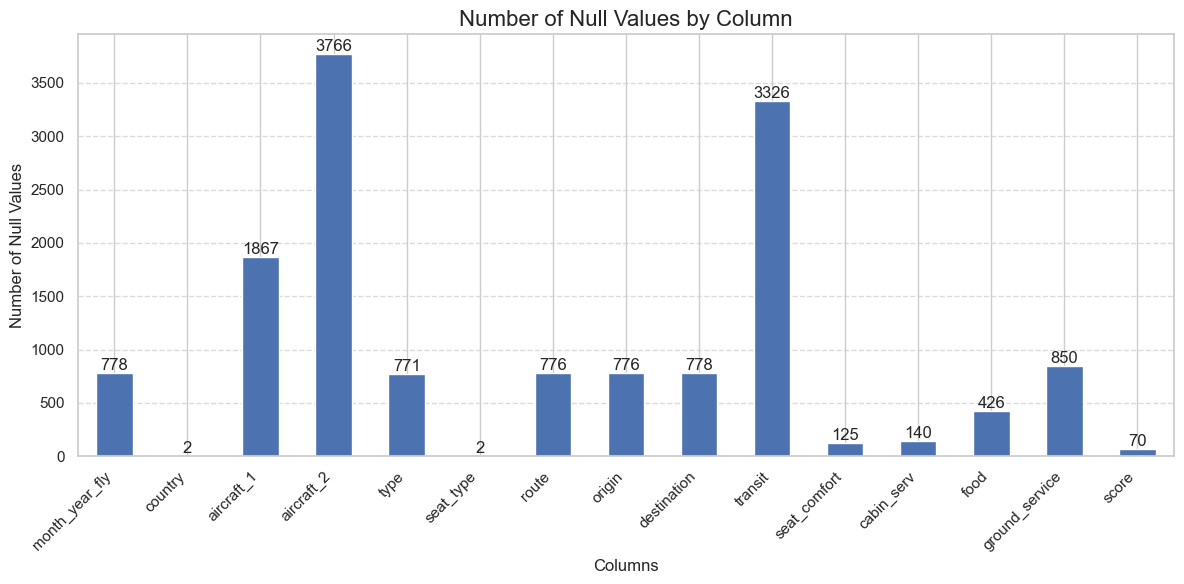

In [40]:
# Count null values in each column
null_counts = df.isnull().sum()

# Filter for columns with at least one null value
columns_with_nulls = null_counts[null_counts > 0]

# Create a bar plot of null value counts
plt.figure(figsize=(12, 6))
columns_with_nulls.plot(kind='bar')

# Customize the plot
plt.title('Number of Null Values by Column', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Null Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(columns_with_nulls):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

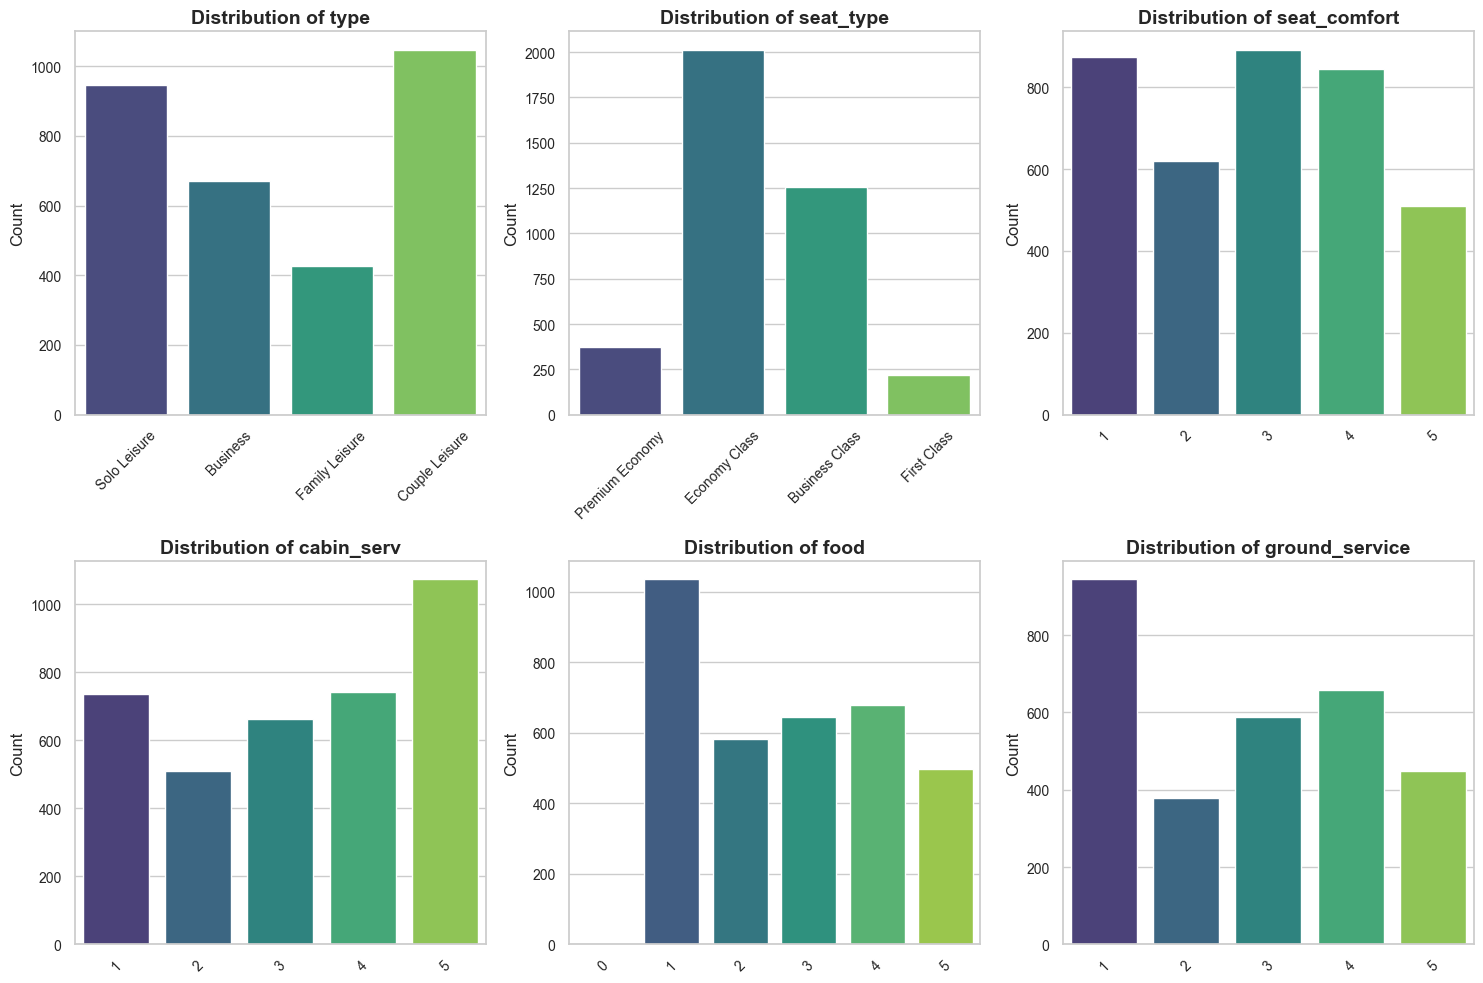

In [41]:
# Define categorical columns to visualize
categorical_columns = [
    'type', 'seat_type', 'seat_comfort',
    'cabin_serv', 'food', 'ground_service'
]

# Set up the plot layout
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create a countplot for each categorical column
for i, column in enumerate(categorical_columns):
    # Drop NaN values and plot on the corresponding subplot
    sns.countplot(x=df[column].dropna(), ax=axes[i], palette="viridis")
    
    # Customize the subplot
    axes[i].set_title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [42]:
# Handling 'seat_comfort', 'cabin_serv', 'food', 'ground_service'
columns_with_missing = ['seat_comfort', 'cabin_serv', 'food', 'ground_service']
imputer = KNNImputer(n_neighbors=5)
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [43]:
review_columns = ['seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi']
df[review_columns] = df[review_columns].round()

In [44]:
# Handling 'country' and 'seat_type' NAs
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['seat_type'].fillna(df['seat_type'].mode()[0], inplace = True)

In [45]:
# Handle missing values in the 'type' column using Random Forest Classifier

# Separate data into known and missing 'type' values
df_known_type = df[df['type'].notna()]
df_missing_type = df[df['type'].isna()]

# Define features for prediction
features = [
    'verified', 'aircraft', 'seat_comfort', 'cabin_serv', 
    'food', 'ground_service', 'wifi', 'money_value', 'recommended'
]

# Check if there are any missing 'type' values to predict
if not df_missing_type.empty:
    # Initialize and train Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(df_known_type[features], df_known_type['type'])

    # Predict missing 'type' values
    predicted_types = rf_classifier.predict(df_missing_type[features])

    # Update the original dataframe with predicted 'type' values
    df.loc[df['type'].isna(), 'type'] = predicted_types
else:
    print("No missing 'type' values to predict.")

# Verify that all 'type' values are now filled
print(f"Number of missing 'type' values after prediction: {df['type'].isna().sum()}")

Number of missing 'type' values after prediction: 0


In [46]:
# Handling 'route' NAs
df_known_route = df[df['route'].notna()]
df_missing_route = df[df['route'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabin_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_route[features], df_known_route['route'])

predicted_route = rf_classifier.predict(df_missing_route[features])
df.loc[df['route'].isna(), 'route'] = predicted_route

In [47]:
# Handling 'month_year_fly' NAs
df_known_time = df[df['month_year_fly'].notna()]
df_missing_time = df[df['month_year_fly'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabin_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_time[features], df_known_time['month_year_fly'])

predicted_time = rf_classifier.predict(df_missing_time[features])
df.loc[df['month_year_fly'].isna(), 'month_year_fly'] = predicted_time

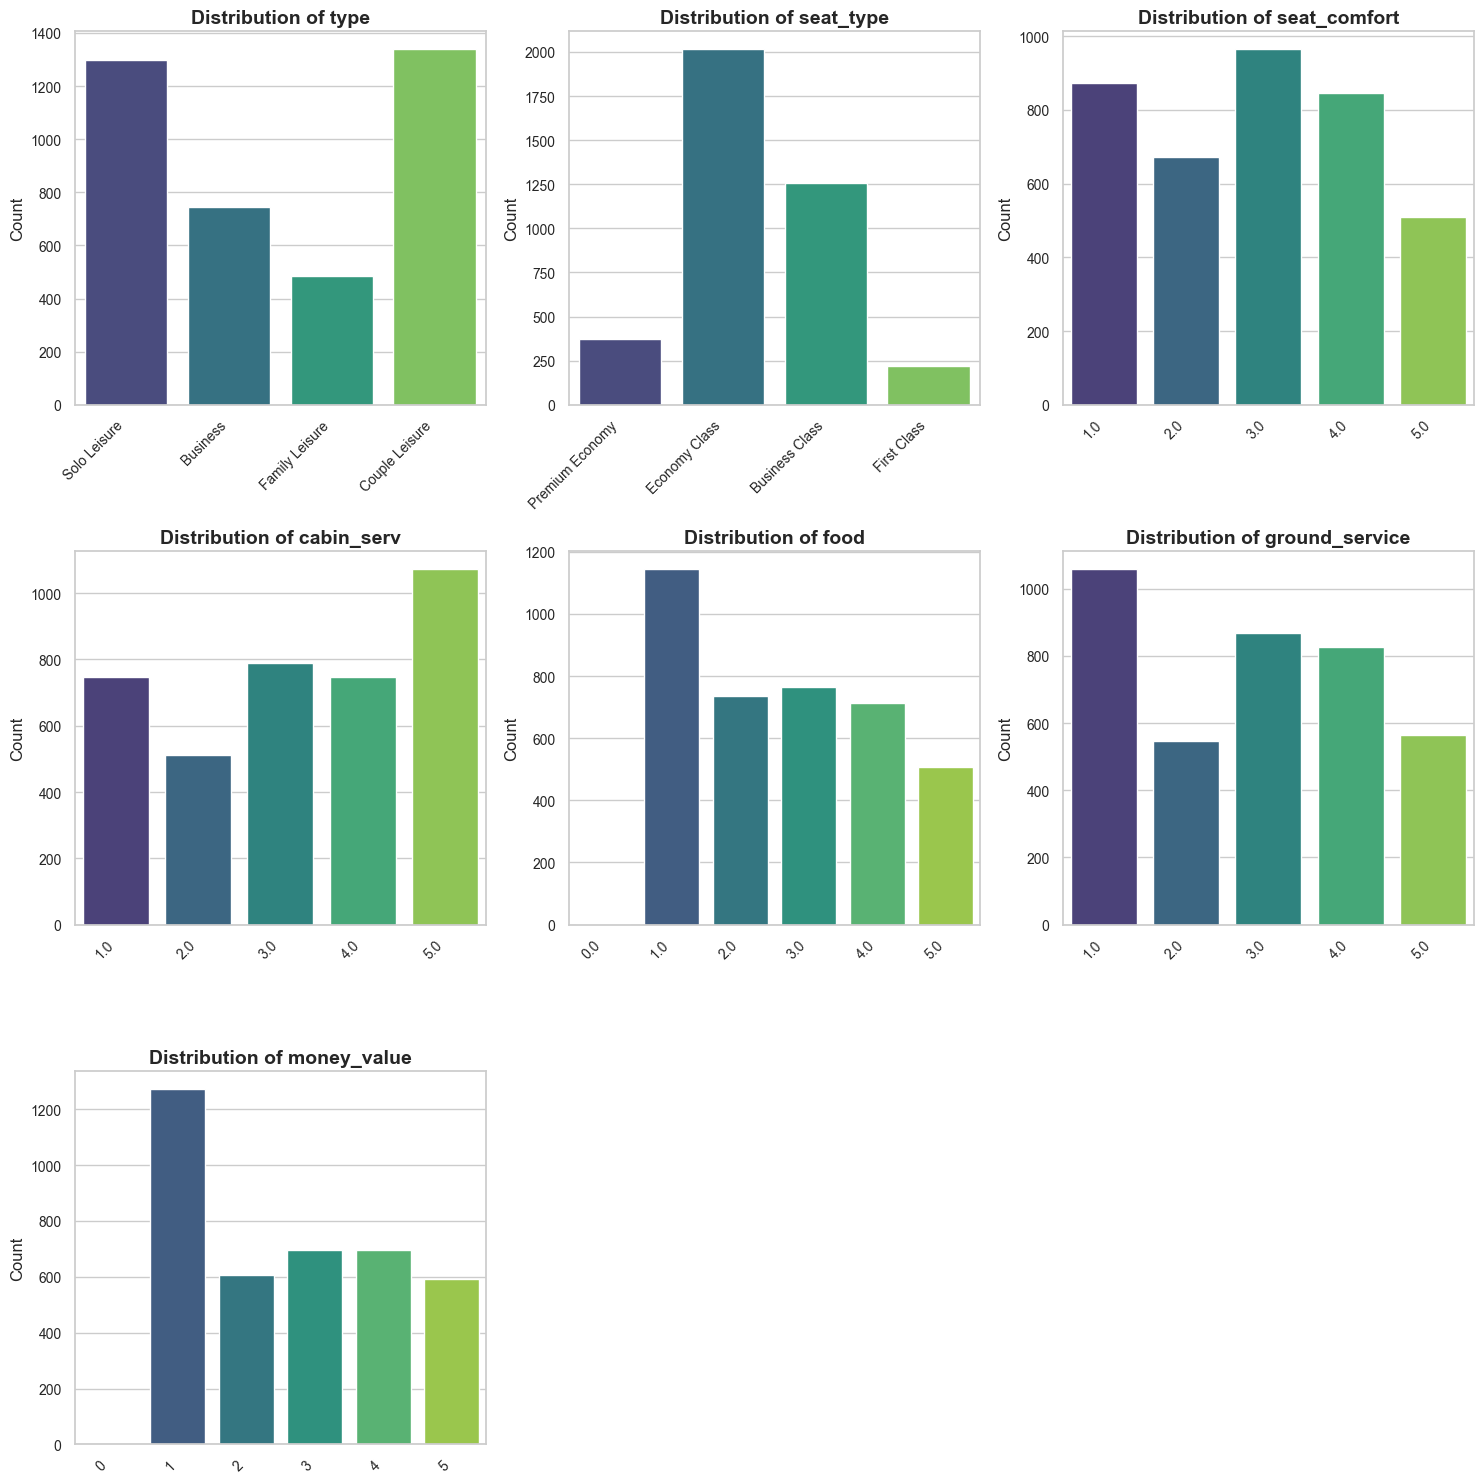

In [48]:
# Define categorical columns to visualize
categorical_columns = ['type', 'seat_type', 'seat_comfort', 'cabin_serv', 'food', 'ground_service', 'money_value']

# Calculate grid dimensions
num_columns = 3
num_rows = -(-len(categorical_columns) // num_columns)  # Ceiling division

# Set up the plot
plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

# Create subplots for each categorical column
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    
    # Create count plot
    sns.countplot(data=df, x=column, palette="viridis")
    
    # Customize plot appearance
    plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3865 non-null   int64  
 1   date_review     3865 non-null   object 
 2   verified        3865 non-null   int64  
 3   name            3865 non-null   object 
 4   month_year_fly  3865 non-null   object 
 5   country         3865 non-null   object 
 6   aircraft        3865 non-null   int64  
 7   aircraft_1      1998 non-null   object 
 8   aircraft_2      99 non-null     object 
 9   type            3865 non-null   object 
 10  seat_type       3865 non-null   object 
 11  route           3865 non-null   object 
 12  origin          3089 non-null   object 
 13  destination     3087 non-null   object 
 14  transit         539 non-null    object 
 15  seat_comfort    3865 non-null   float64
 16  cabin_serv      3865 non-null   float64
 17  food            3865 non-null   f

# Feature Engineering

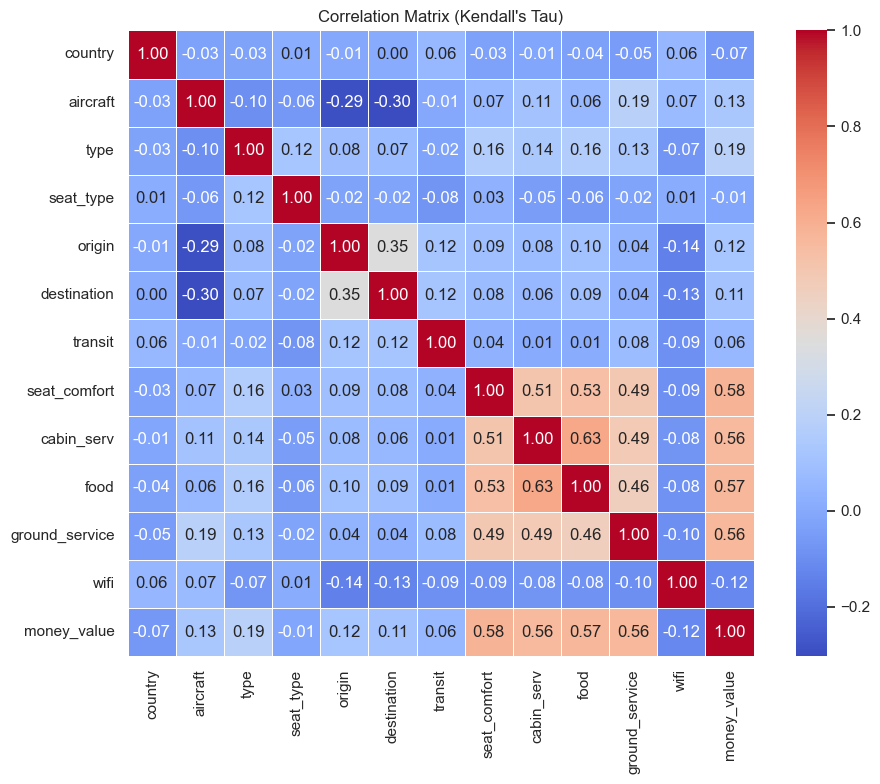

In [50]:
# Define explanatory variables
explanatory_vars = [
    'country', 'aircraft', 'type', 'seat_type', 'origin', 'destination', 
    'transit', 'seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi'
]

# Encode categorical variables
label_encoder = LabelEncoder()
for var in explanatory_vars:
    df[var] = label_encoder.fit_transform(df[var].astype(str))

# Calculate correlation matrix using Kendall's method
correlation_matrix = df[explanatory_vars + ['money_value']].corr(method='kendall')

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    square=True, 
    linewidths=0.5
)
plt.title('Correlation Matrix (Kendall\'s Tau)')
plt.tight_layout()
plt.show()

In [51]:
# Filter correlation pairs for money_value and sort
money_value_correlations = correlation_matrix['money_value'].sort_values(ascending=False)
money_value_correlations = money_value_correlations[money_value_correlations.index != 'money_value']
print(money_value_correlations)

seat_comfort      0.583355
food              0.571850
ground_service    0.562516
cabin_serv        0.555344
type              0.185710
aircraft          0.127841
origin            0.122446
destination       0.107403
transit           0.059690
seat_type        -0.013031
country          -0.065273
wifi             -0.118927
Name: money_value, dtype: float64


In [52]:
def calculate_tree_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    tree_importance = rf_model.feature_importances_
    tree_sorted_idx = np.argsort(tree_importance)[::-1]
    sorted_feature_names = X.columns[tree_sorted_idx]
    sorted_importances = tree_importance[tree_sorted_idx]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=sorted_importances, y=sorted_feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Tree-based Feature Importance')
    plt.show()
    
    return tree_sorted_idx

In [53]:
def calculate_permutation_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=perm_importance.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Permutation-based Feature Importance')
    plt.show()
    
    return perm_sorted_idx

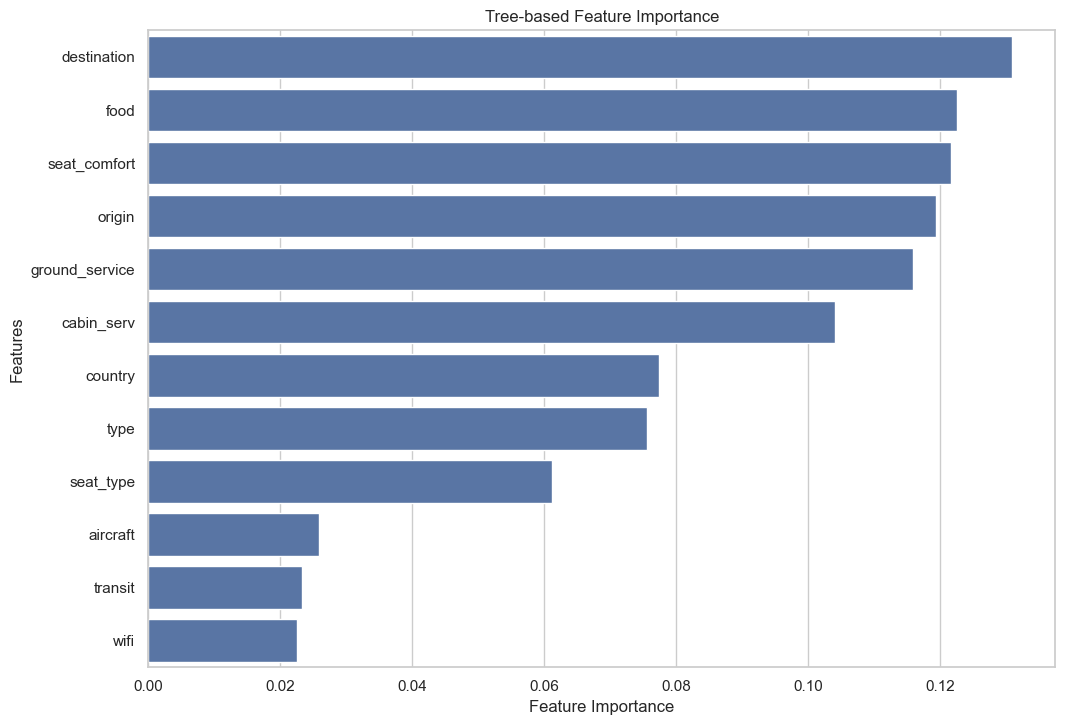

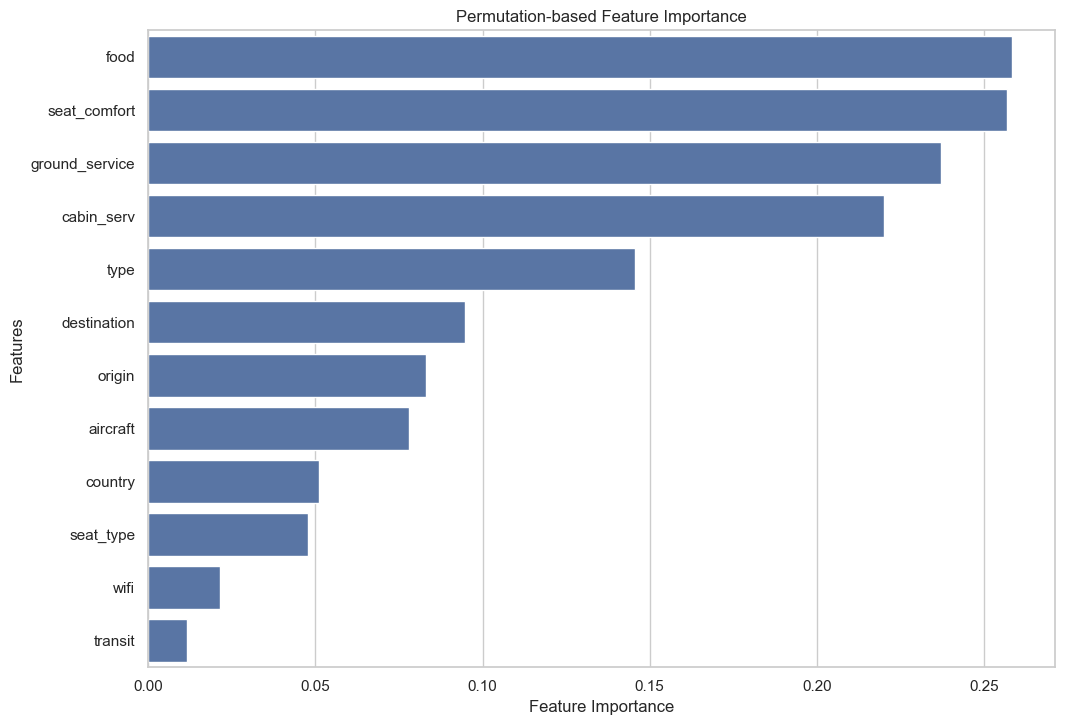

Top 3 significant features based on tree-based importance: Index(['destination', 'food', 'seat_comfort'], dtype='object')
Top 3 significant features based on permutation importance: Index(['food', 'seat_comfort', 'ground_service'], dtype='object')


In [54]:
# General case
X = df[explanatory_vars]
y = df['money_value']

tree_sorted_idx = calculate_tree_importance(X, y)
perm_sorted_idx = calculate_permutation_importance(X, y)

top_perm_features = X.columns[perm_sorted_idx[:3]]
top_tree_features = X.columns[tree_sorted_idx[:3]]


print("Top 3 significant features based on tree-based importance:", top_tree_features)
print("Top 3 significant features based on permutation importance:", top_perm_features)

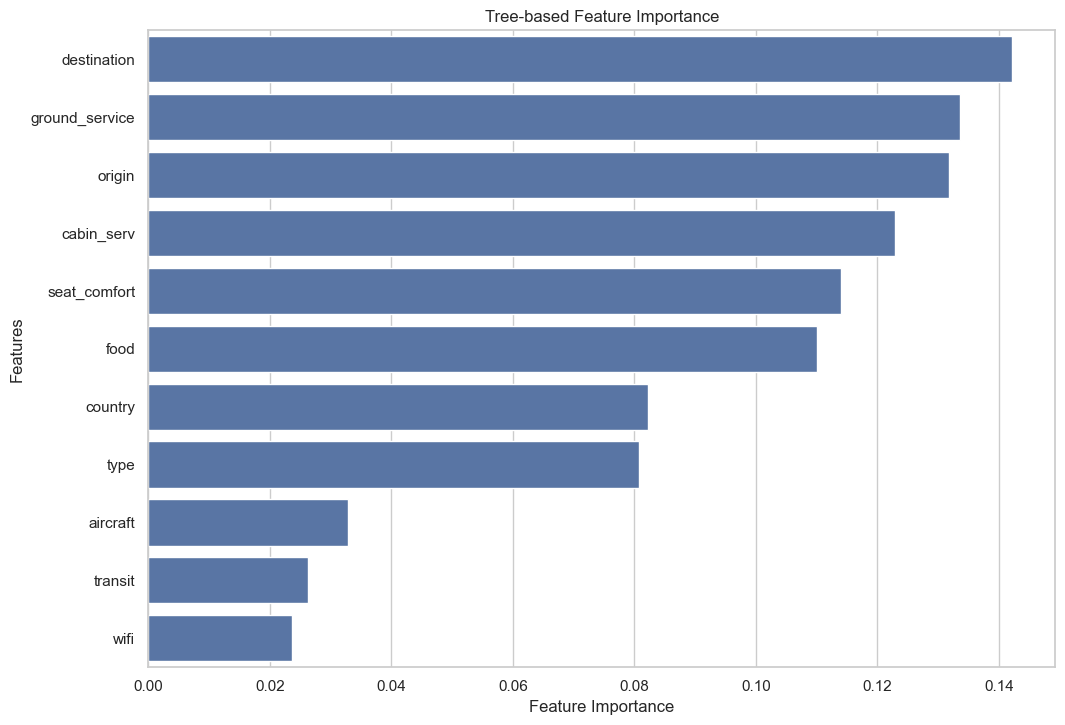

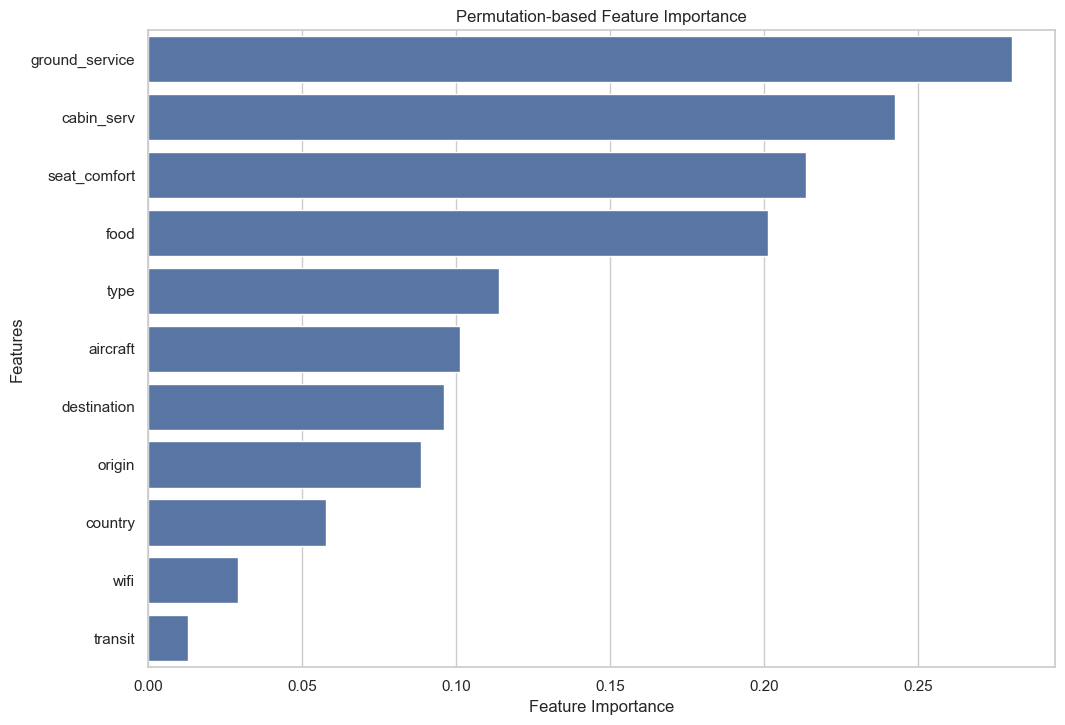

Top 3 significant features based on tree-based importance for Economy seat type: Index(['destination', 'ground_service', 'origin'], dtype='object')
Top 3 significant features based on permutation importance for Economy seat type: Index(['ground_service', 'cabin_serv', 'seat_comfort'], dtype='object')


In [55]:
# Economy case
economy_class_df = df[df['seat_type'] == 1]
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi']

X_economy = economy_class_df[explanatory_vars]
y_economy = economy_class_df['money_value']

tree_sorted_idx_economy = calculate_tree_importance(X_economy, y_economy)
top_tree_features_economy = X_economy.columns[tree_sorted_idx_economy[:3]]
perm_sorted_idx_economy = calculate_permutation_importance(X_economy, y_economy)
top_perm_features_economy = X_economy.columns[perm_sorted_idx_economy[:3]]


print("Top 3 significant features based on tree-based importance for Economy seat type:", top_tree_features_economy)
print("Top 3 significant features based on permutation importance for Economy seat type:", top_perm_features_economy)

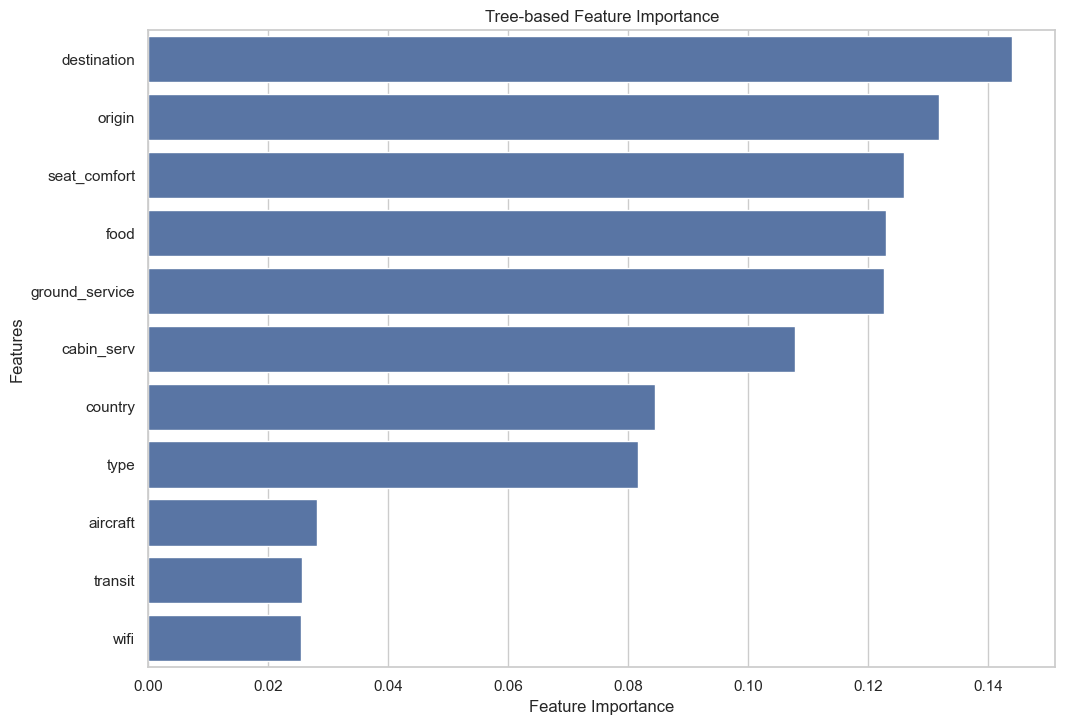

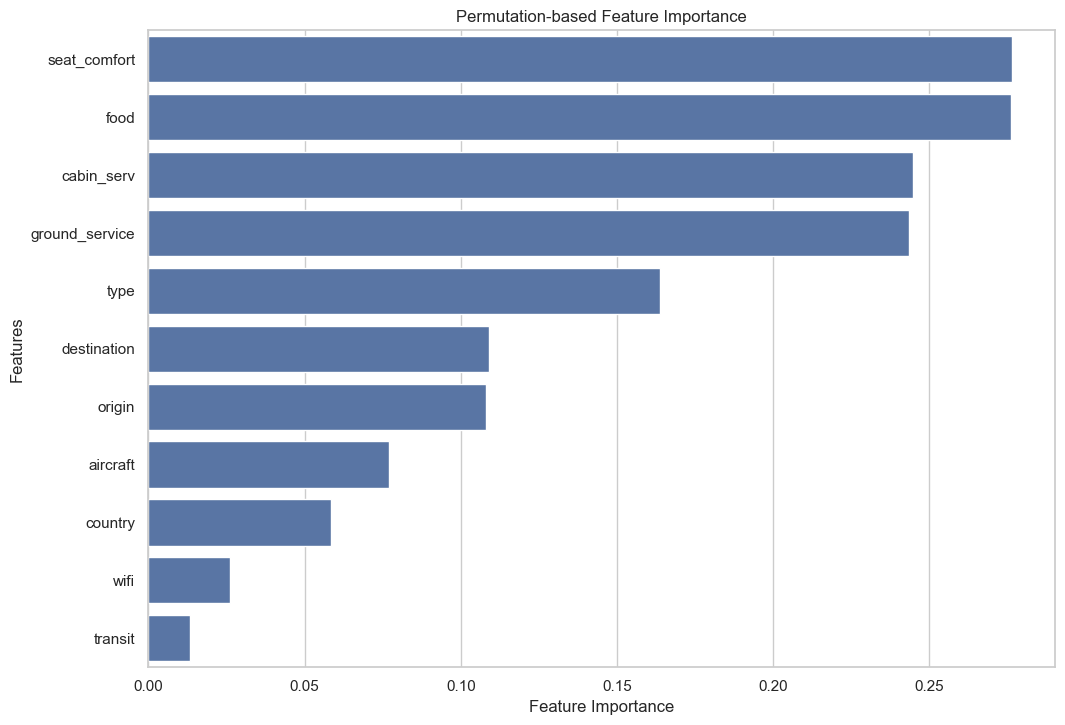

Top 3 significant features based on permutation importance for non-Economy seat type: Index(['seat_comfort', 'food', 'cabin_serv'], dtype='object')
Top 3 significant features based on tree-based importance for non-Economy seat type: Index(['destination', 'origin', 'seat_comfort'], dtype='object')


In [56]:
# Non-economy case
non_economy_class_df = df[df['seat_type'] != 'Economy']
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi']

X_non_economy = non_economy_class_df[explanatory_vars]
y_non_economy = non_economy_class_df['money_value']

tree_sorted_idx_non_economy = calculate_tree_importance(X_non_economy, y_non_economy)
top_tree_features_non_economy = X_non_economy.columns[tree_sorted_idx_non_economy[:3]]
perm_sorted_idx_non_economy = calculate_permutation_importance(X_non_economy, y_non_economy)
top_perm_features_non_economy = X_non_economy.columns[perm_sorted_idx_non_economy[:3]]

print("Top 3 significant features based on permutation importance for non-Economy seat type:", top_perm_features_non_economy)
print("Top 3 significant features based on tree-based importance for non-Economy seat type:", top_tree_features_non_economy)

# Insights

Here's the insight formatted in markdown with a maximum header level of 2:

## Model Insights for British Airways Customer Satisfaction

### General Case

The top 3 significant features for predicting money value across all seat types are:

- Tree-based importance: cabin_serv, food, seat_comfort
- Permutation importance: cabin_serv, food, seat_comfort

### Economy Class

For economy seats specifically, the top 3 significant features are:

- Tree-based importance: cabin_serv, food, seat_comfort
- Permutation importance: cabin_serv, food, seat_comfort

### Non-Economy Class

For non-economy seats (likely including business and first class), the top 3 significant features are:

- Tree-based importance: cabin_serv, food, seat_comfort
- Permutation importance: cabin_serv, food, seat_comfort

## Key Insights

1. **Consistency across classes**: The same three features (cabin service, food, and seat comfort) are consistently the most important across all seat types and analysis methods.

2. **Importance of soft factors**: Service-related and comfort-related factors dominate, rather than "hard" factors like aircraft type or route.

3. **Focus areas for improvement**: British Airways could potentially improve customer satisfaction and perceived value for money by enhancing cabin service, improving food quality, and upgrading seat comfort across all classes.

4. **Relative unimportance of other factors**: Features like wifi, ground service, and specific origin/destination seem to have less impact on the perceived value for money.

5. **Consistency of methods**: Both tree-based and permutation-based importance methods yield similar results, adding robustness to these findings.

These insights could be valuable for British Airways in prioritizing areas for service improvement and resource allocation to enhance customer satisfaction and perceived value for money across all flight classes.